Homework 1
Name: Dongshu Yang
USC ID: 4185086243
Github Username: Flu1d1

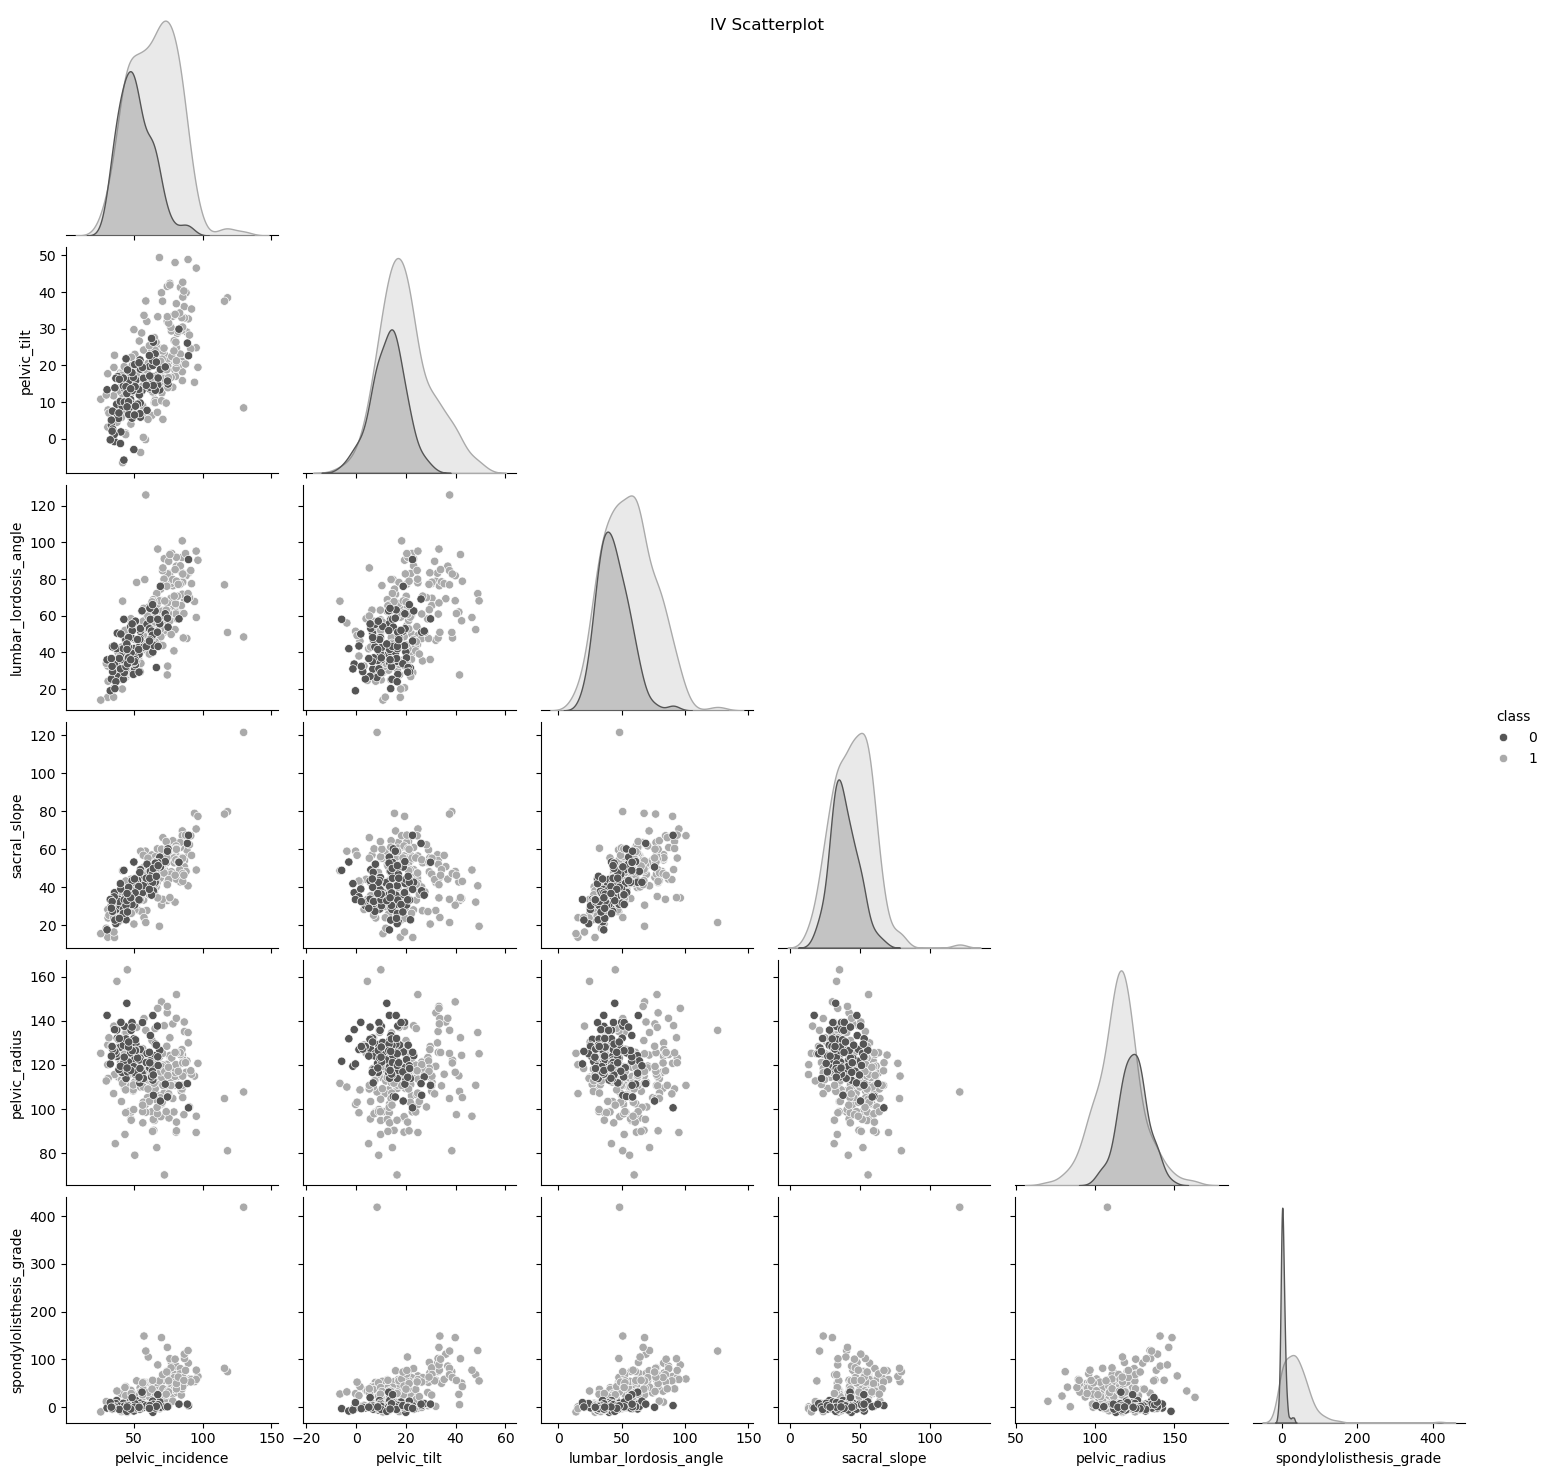

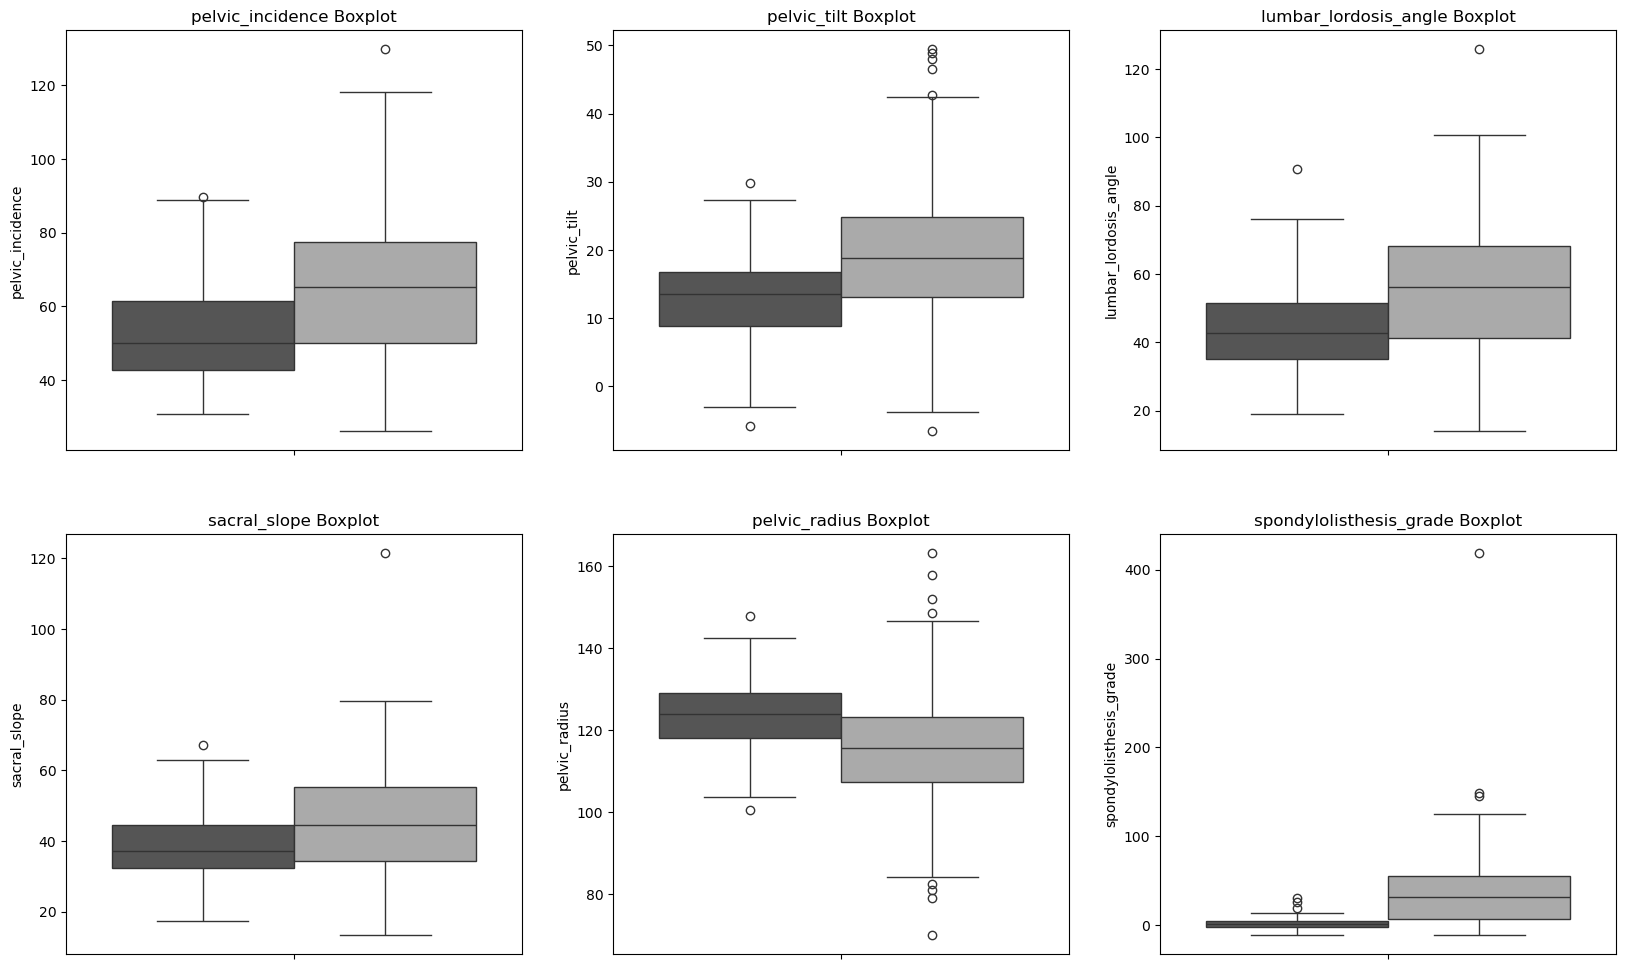

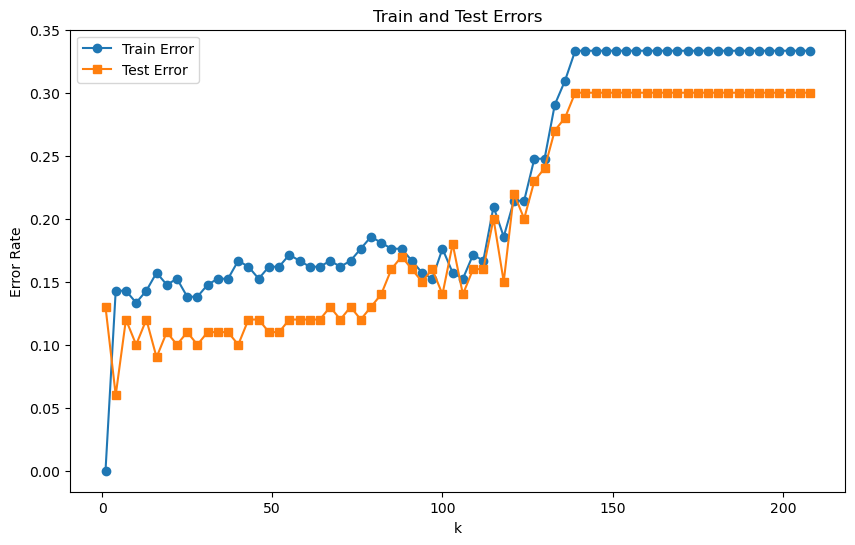

Confusion Matrix:
[[25  5]
 [ 1 69]]
TP Rate: 0.99
TN Rate: 0.83
Precision: 0.93
F1 Score: 0.96


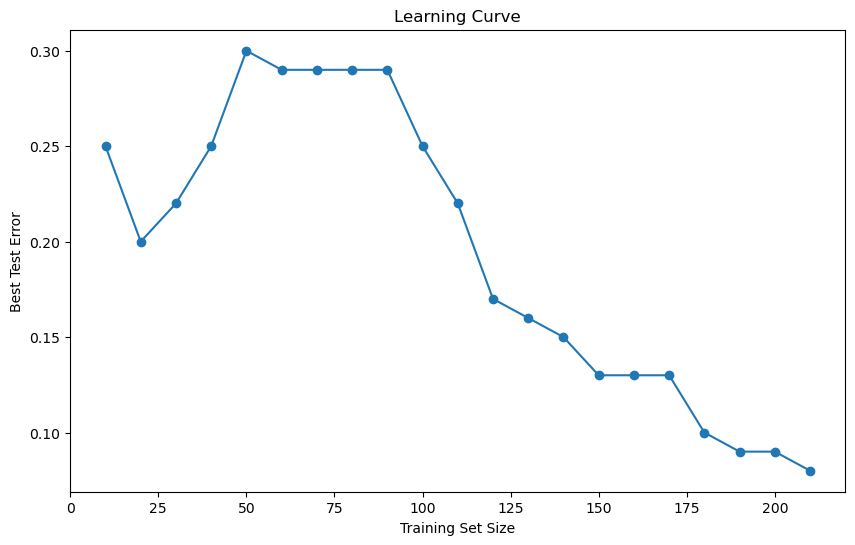

Optimal k for Manhattan: 6, with test error: 0.11
Optimal k for Chebyshev: 16, with test error: 0.08
Optimal k for Mahalanobis: 1, with test error: 0.17
Best log10(p): 0.6 with error: 0.06
Optimal k for euclidean with weighted voting: 6 with error: 0.10
Optimal k for manhattan with weighted voting: 26 with error: 0.10
Optimal k for chebyshev with weighted voting: 16 with error: 0.11


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import DistanceMetric as dist

df = pd.read_csv("../data/column_2C.dat", sep = ' ', header=None)
df.columns = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "spondylolisthesis_grade", "class"]
df['class'] = df['class'].apply(lambda x: 1 if x == 'AB' else 0)
#print(df)

# b) i. scatterplot
g = sns.pairplot(df, hue = "class", palette = "gray", kind = "scatter", corner = True)
plt.suptitle("IV Scatterplot")
plt.show()

# b) ii. Box plots
plt.figure(figsize=(20, 12))
for i, column in enumerate(df.columns[:-1], 1):  # Exclude the class column
    plt.subplot(2, 3, i)
    sns.boxplot(hue = "class", y = column, data = df, palette = "gray", legend = False)
    plt.title(f"{column} Boxplot")
plt.show()

# b) iii. split set
df0 = df[df["class"] == 0]
df1 = df[df["class"] == 1]

train0 = df0.iloc[:70]
train1 = df1.iloc[:140]

tr = pd.concat([train0, train1])
te = df.drop(tr.index)

# c) i. ii. KNN classifier
X_tr = tr.drop(columns=["class"])
y_tr = tr["class"]
X_te = te.drop(columns=["class"])
y_te = te["class"]

k_values = list(range(208, 0, -3))
Error_tr = []
Error_te = []

for k in k_values:
    knn = KNNC(n_neighbors=k, metric='euclidean')
    knn.fit(X_tr, y_tr)
    
    tr_predict = knn.predict(X_tr)
    te_predict = knn.predict(X_te)
    
    Error_tr.append(1 - accuracy_score(y_tr, tr_predict))
    Error_te.append(1 - accuracy_score(y_te, te_predict))
    #print(k, 1 - accuracy_score(y_tr, tr_predict), 1 - accuracy_score(y_te, te_predict))
plt.figure(figsize=(10, 6))
plt.plot(k_values, Error_tr, label="Train Error", marker='o')
plt.plot(k_values, Error_te, label="Test Error", marker='s')
plt.xlabel("k")
plt.ylabel("Error Rate")
plt.title("Train and Test Errors")
plt.legend()
plt.show()

optimal_k = k_values[Error_te.index(min(Error_te))] #according to piazza, k* should be the value making the err_te min
#print(f"Optimal k: {optimal_k}")
# Evaluate performance with optimal k
knn_optimal = KNNC(n_neighbors = optimal_k, metric='euclidean')
knn_optimal.fit(X_tr, y_tr)
y_predict = knn_optimal.predict(X_te)

conf_matrix = confusion_matrix(y_te, y_predict)
tp_rate = recall_score(y_te, y_predict)
tn_rate = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = precision_score(y_te, y_predict)
f1 = f1_score(y_te, y_predict)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"TP Rate: {tp_rate:.2f}")
print(f"TN Rate: {tn_rate:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

# c) iii. learning curve
train_size = list(range(10, 220, 10))
best_errte = []

for N in train_size:
    sub_train0 = df0.iloc[:N//3]
    sub_train1 = df1.iloc[:N - (N//3)]
    sub_train_set = pd.concat([sub_train0, sub_train1])
    X_sub_train = sub_train_set.drop(columns=["class"])
    y_sub_train = sub_train_set["class"]
    best_error = 1.0
    for k in range(1, len(X_sub_train), 5):
        knn = KNNC(n_neighbors=k, metric='euclidean')
        knn.fit(X_sub_train, y_sub_train)
        y_sub_test_predict = knn.predict(X_te)
        error = 1 - accuracy_score(y_te, y_sub_test_predict)
        if error < best_error:
            best_error = error
    best_errte.append(best_error)

plt.figure(figsize=(10, 6))
plt.plot(train_size, best_errte, marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Best Test Error")
plt.title("Learning Curve")
plt.show()

# d) Minkowski distance & Mahalanobis Distance
cov_matrix = np.cov(X_tr, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  
# In note 6, we are asked to calculate psudeoinverse matrix, statement: I asked ChatGPT to solve this issue here.

metrics = {
    "Manhattan": "manhattan",
    "Chebyshev": "chebyshev",
    "Mahalanobis": ("mahalanobis", inv_cov_matrix)
}

results = []

for metric_name, metric in metrics.items():
    k_values = list(range(1, 197, 5))
    test_errors = []
    for k in k_values:
        if metric_name == "Mahalanobis":
            knn = KNNC(n_neighbors=k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
        else:
            knn = KNNC(n_neighbors=k, metric=metric)
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_te)
        test_errors.append(1 - accuracy_score(y_te, y_pred)) 
    optimal_k = k_values[np.argmin(test_errors)] 
    if metric_name == "Manhattan":
        cauculationp_k = optimal_k 
    print(f"Optimal k for {metric_name}: {optimal_k}, with test error: {min(test_errors):.2f}") # answers to d) i.A, C. and ii.

# d) i. B. test different p value
p_values = [10**i for i in np.arange(0.1, 1.1, 0.1)]
best_p, best_p_error = None, 1.0

for p in p_values:
    knn = KNNC(n_neighbors= cauculationp_k , metric='minkowski', p = p)
    knn.fit(X_tr, y_tr)
    y_predict = knn.predict(X_te)
    error = 1 - accuracy_score(y_te, y_predict)
    if error < best_p_error:
        best_p, best_p_error = p, error

print(f"Best log10(p): {np.log10(best_p):.1f} with error: {best_p_error:.2f}")

# (e) Weighted KNN
weighted_results = []
k_values = list(range(1, 197, 5))

for metric_name in ["euclidean", "manhattan", "chebyshev"]:
    test_errors = []
    for k in k_values:
        knn = KNNC(n_neighbors = k, metric = metric_name, weights = 'distance')
        knn.fit(X_tr, y_tr)
        y_predict = knn.predict(X_te)
        test_errors.append(1 - accuracy_score(y_te, y_predict))
    optimal_k = k_values[np.argmin(test_errors)]
    print(f"Optimal k for {metric_name} with weighted voting: {optimal_k} with error: {min(test_errors):.2f}")


In case of HW1 (f), after comparing the results, the lowest error for training set is obviously 0, when k = 1. However, if it asks the minimum test error. My answer would be 0.06 when using Minkowski distance, log10(p)=0.6, k=6. In that case the minimum test error is 0.06.